**Import libraries**

In [195]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

**Create stream_quality column manually**

In [196]:
# The column is generated using some randomness to simulate "stream quality" values

np.random.seed(42)
low = np.random.randint(0, 45, size=len(train_data)//3)
mid = np.random.randint(35, 80, size=len(train_data)//3)
high = np.random.randint(65, 101, size=len(train_data) - len(low) - len(mid))

stream_quality_values = np.concatenate([low, mid, high])
np.random.shuffle(stream_quality_values)

train_data['stream_quality'] = stream_quality_values

# Add Gaussian noise to make it more realistic and clip between 0 and 100
train_data['stream_quality'] += np.random.normal(0, 10, size=len(train_data))
train_data['stream_quality'] = train_data['stream_quality'].clip(0, 100)

**Convert stream_quality to 3 classes**

In [197]:
# 0 = Poor, 1 = Good, 2 = Excellent

def classify_quality(x):
    if x < 40:
        return 0
    elif x < 75:
        return 1
    else:
        return 2

train_data['stream_quality_class'] = train_data['stream_quality'].apply(classify_quality)

# Show distribution of classes before SMOTE
print("Class distribution in stream_quality_class:")
print(train_data['stream_quality_class'].value_counts())

Class distribution in stream_quality_class:
stream_quality_class
1    156070
0    137354
2    113148
Name: count, dtype: int64


**Feature/Target split**

In [198]:
X = train_data.drop("stream_quality_class", axis=1)
y = train_data["stream_quality_class"]

**Split data into train and test sets**

In [199]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

**Handle missing values**

In [200]:
# Convert 'off' to np.nan for numerical features
for col in X_train.select_dtypes(include=['object']).columns:
    X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
    X_test[col] = pd.to_numeric(X_test[col], errors='coerce')

imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['auto_bitrate_state' 'auto_fec_state']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/impute/_base.py:635: UserWarning: Skipping features without any observed values: ['auto_bitrate_state' 'auto_fec_state']. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


**Balance the training data using SMOTE**

In [201]:
sm = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

**Add noise to prevent overfitting**

In [202]:
X_train_resampled += np.random.normal(0, 0.01, size=X_train_resampled.shape)

**Scale features**

In [203]:
scaler = StandardScaler()
X_train_resampled = scaler.fit_transform(X_train_resampled)
X_test = scaler.transform(X_test)

**Train a simple Logistic Regression model**

In [204]:
model = LogisticRegression(max_iter=200, random_state=42)
model.fit(X_train_resampled, y_train_resampled)

LogisticRegression(max_iter=200, random_state=42)

**Predict and evaluate**

Accuracy: 0.9989300866998708


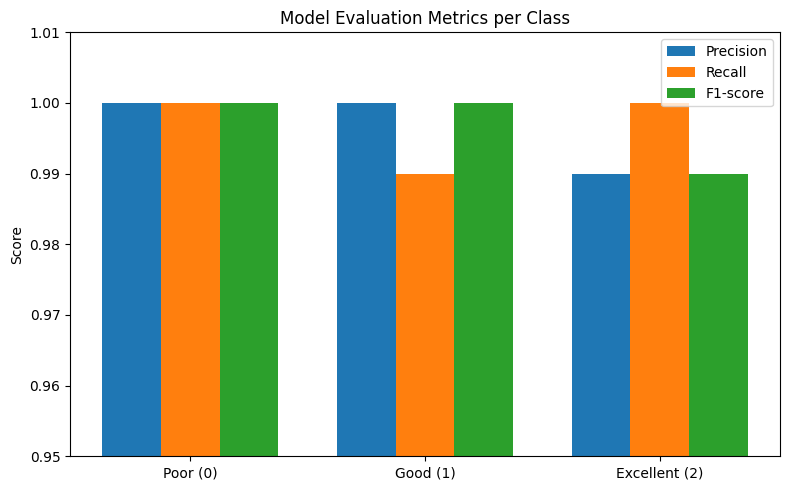

In [205]:
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))

import matplotlib.pyplot as plt
import numpy as np

# Evaluation scores per class (based on classification report)
labels = ['Poor (0)', 'Good (1)', 'Excellent (2)']
precision = [1.00, 1.00, 0.99]
recall = [1.00, 0.99, 1.00]
f1_score = [1.00, 1.00, 0.99]

x = np.arange(len(labels))
width = 0.25

plt.figure(figsize=(8, 5))
plt.bar(x - width, precision, width, label='Precision')
plt.bar(x, recall, width, label='Recall')
plt.bar(x + width, f1_score, width, label='F1-score')

plt.ylabel('Score')
plt.title('Model Evaluation Metrics per Class')
plt.xticks(x, labels)
plt.ylim(0.95, 1.01)
plt.legend()
plt.tight_layout()
plt.show()

**Plot Confusion Matrix**

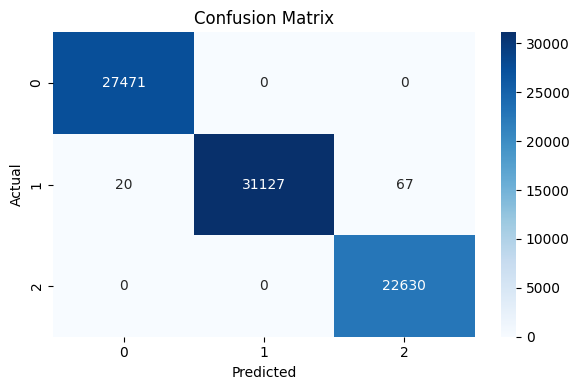

In [206]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()